# Setup libraries and constants

In [1]:
import datetime
import pathlib
import time
from os import listdir
from os.path import isfile, join

import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import numpy as np
import random
from IPython.display import clear_output
from PIL import Image
from tensorflow_addons.image import gaussian_filter2d

task = 'flower' # flower = 43 mins/epoch

AUTOTUNE = tf.data.experimental.AUTOTUNE

config = tf.compat.v1.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.8
tf.compat.v1.keras.backend.set_session(tf.compat.v1.Session(config=config))

base_path = "../"
CHECKPOINT_PATH = base_path+"res/checkpoints/train"

add_path = 'jpg/' if task == 'flower' else ''

x_train = pathlib.Path(base_path+"res/dataset/x/train/"+add_path)
y_train = pathlib.Path(base_path+"res/dataset/y/train/"+add_path)
x_test = pathlib.Path(base_path+"res/dataset/x/test/"+add_path)
y_test = pathlib.Path(base_path+"res/dataset/y/test/"+add_path)
x_val = pathlib.Path(base_path+"res/dataset/x/val/"+add_path)
y_val = pathlib.Path(base_path+"es/dataset/y/val/"+add_path)

SEED = 42

random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

RESIZE_H = 286
RESIZE_W = 286

BUFFER_SIZE = 500
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256

LR = 2e-4
NORM = 'instancenorm'  # 'batchnorm'
LAMBDA = 10
BETA = 0.5  # 0.999
DISC_TERM = 0.5
ID_TERM = 0.5

EPOCHS = 100
EPOCH_CHECKPOINT = 1
MAX_CHECKPOINT = 5

sigma_blur = 0 if task == 'flower' else 1
filter_shape = (4, 4)

OUTPUT_CHANNELS = 1 if task == 'flower' else 3
OUTPUT_CHANNELS_G = 3
OUTPUT_CHANNELS_F = OUTPUT_CHANNELS

loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

# Prepare the dataset

In [2]:
list_ds_x_train = tf.data.Dataset.list_files(str(x_train/'*'))
list_ds_y_train = tf.data.Dataset.list_files(str(y_train/'*'))

#for f in list_ds_x_train.take(5):
#    print(f.numpy())

In [3]:
def decode_img_bw(img):
    # convert the compressed string to a 3D uint8 tensor
    img = tf.image.decode_jpeg(img, channels=OUTPUT_CHANNELS)
    # Use `convert_image_dtype` to convert to floats in the [0,1] range.
    img = tf.image.convert_image_dtype(img, tf.float32)
    # resize the image to the desired size.
    return tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT])
    #return img

def decode_img_rgb(img):
    # convert the compressed string to a 3D uint8 tensor
    img = tf.image.decode_jpeg(img, channels=3)
    # Use `convert_image_dtype` to convert to floats in the [0,1] range.
    img = tf.image.convert_image_dtype(img, tf.float32)
    # resize the image to the desired size.
    return tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT])
    #return img

def process_path_bw(file_path):
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img_bw(img)
    return img

def process_path_rgb(file_path):
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img_rgb(img)
    return img

ds_x_train = list_ds_x_train.map(process_path_bw, num_parallel_calls=AUTOTUNE)
ds_y_train = list_ds_y_train.map(process_path_rgb, num_parallel_calls=AUTOTUNE)

In [4]:
def random_crop(image):
    cropped_image = tf.image.random_crop(image, size=[IMG_HEIGHT, IMG_WIDTH, OUTPUT_CHANNELS])

    return cropped_image

# normalizing the images to [-1, 1]
def normalize(image):
    image = tf.cast(image, tf.float32)
    image = (image / 127.5) - 1
    return image

def random_jitter(image):
    # resizing to 286 x 286 x 3
    image = tf.image.resize(image, [RESIZE_H, RESIZE_W],
                          method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

    # randomly cropping to 256 x 256 x 3
    image = random_crop(image)

    # random mirroring
    image = tf.image.random_flip_left_right(image)

    return image

def blur(image):
    res = gaussian_filter2d(image, filter_shape=filter_shape, sigma=sigma_blur)
    return res

def preprocess_image_train_x(image):
    if task != 'flower':
        image = random_jitter(image)
    image = normalize(image)
    return image

def preprocess_image_train_y(image):
    if task != 'flower':
        image = random_jitter(image)
    if sigma_blur > 0:
        image = blur(image)
    image = normalize(image)
    return image

def preprocess_image_test(image):
    image = normalize(image)
    return image

ds_x_train = ds_x_train.map(
    preprocess_image_train_x, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

ds_y_train = ds_y_train.map(
    preprocess_image_train_y, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

"""test_horses = test_horses.map(
    preprocess_image_test, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(1)"""

sample_x = next(iter(ds_x_train))
sample_y = next(iter(ds_y_train))
"""
img_x = sample_x.numpy()[0]*255 # and comment normalize
cv2.imwrite('/home/alby/Downloads/image_x.jpg', img_x)
img_y = sample_y.numpy()[0]*255 # and comment normalize
cv2.imwrite('/home/alby/Downloads/image_y.jpg', cv2.cvtColor(img_y, cv2.COLOR_RGB2BGR))
"""

"\nimg_x = sample_x.numpy()[0]*255 # and comment normalize\ncv2.imwrite('/home/alby/Downloads/image_x.jpg', img_x)\nimg_y = sample_y.numpy()[0]*255 # and comment normalize\ncv2.imwrite('/home/alby/Downloads/image_y.jpg', cv2.cvtColor(img_y, cv2.COLOR_RGB2BGR))\n"

# Model

## Generator and discriminator

In [5]:
class InstanceNormalization(tf.keras.layers.Layer):
    """Instance Normalization Layer (https://arxiv.org/abs/1607.08022)."""
    def __init__(self, epsilon=1e-5):
        super(InstanceNormalization, self).__init__()
        self.epsilon = epsilon
    
    def build(self, input_shape):
        self.scale = self.add_weight(
            name='scale',
            shape=input_shape[-1:],
            initializer=tf.random_normal_initializer(1., 0.02),
            trainable=True)
        
        self.offset = self.add_weight(
            name='offset',
            shape=input_shape[-1:],
            initializer='zeros',
            trainable=True)
    
    def call(self, x):
        mean, variance = tf.nn.moments(x, axes=[1, 2], keepdims=True)
        inv = tf.math.rsqrt(variance + self.epsilon)
        normalized = (x - mean) * inv
        return self.scale * normalized + self.offset
  
def downsample(filters, size, norm_type='batchnorm', apply_norm=True):
    """Downsamples an input.
    Conv2D => Batchnorm => LeakyRelu
    Args:
    filters: number of filters
    size: filter size
    norm_type: Normalization type; either 'batchnorm' or 'instancenorm'.
    apply_norm: If True, adds the batchnorm layer
    Returns:
    Downsample Sequential Model
    """
    initializer = tf.random_normal_initializer(0., 0.02)
    
    result = tf.keras.Sequential()
    result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))
    
    if apply_norm:
        if norm_type.lower() == 'batchnorm':
            result.add(tf.keras.layers.BatchNormalization())
    elif norm_type.lower() == 'instancenorm':
        result.add(InstanceNormalization())
    
    result.add(tf.keras.layers.LeakyReLU())
    
    return result

def upsample(filters, size, norm_type='batchnorm', apply_dropout=False):
    """Upsamples an input.
    Conv2DTranspose => Batchnorm => Dropout => Relu
    Args:
    filters: number of filters
    size: filter size
    norm_type: Normalization type; either 'batchnorm' or 'instancenorm'.
    apply_dropout: If True, adds the dropout layer
    Returns:
    Upsample Sequential Model
    """
    
    initializer = tf.random_normal_initializer(0., 0.02)
    
    result = tf.keras.Sequential()
    result.add(
      tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))
    
    if norm_type.lower() == 'batchnorm':
        result.add(tf.keras.layers.BatchNormalization())
    elif norm_type.lower() == 'instancenorm':
        result.add(InstanceNormalization())
    
    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))
    
    result.add(tf.keras.layers.ReLU())
    
    return result

def unet_generator(input_channels, output_channels, norm_type='batchnorm'):
    """Modified u-net generator model (https://arxiv.org/abs/1611.07004).
    Args:
    output_channels: Output channels
    norm_type: Type of normalization. Either 'batchnorm' or 'instancenorm'.
    Returns:
    Generator model
    """
    
    down_stack = [
        downsample(64, 4, norm_type, apply_norm=False),  # (bs, 128, 128, 64)
        downsample(128, 4, norm_type),  # (bs, 64, 64, 128)
        downsample(256, 4, norm_type),  # (bs, 32, 32, 256)
        downsample(512, 4, norm_type),  # (bs, 16, 16, 512)
        downsample(512, 4, norm_type),  # (bs, 8, 8, 512)
        downsample(512, 4, norm_type),  # (bs, 4, 4, 512)
        downsample(512, 4, norm_type),  # (bs, 2, 2, 512)
        downsample(512, 4, norm_type),  # (bs, 1, 1, 512)
    ]
    
    up_stack = [
        upsample(512, 4, norm_type, apply_dropout=True),  # (bs, 2, 2, 1024)
        upsample(512, 4, norm_type, apply_dropout=True),  # (bs, 4, 4, 1024)
        upsample(512, 4, norm_type, apply_dropout=True),  # (bs, 8, 8, 1024)
        upsample(512, 4, norm_type),  # (bs, 16, 16, 1024)
        upsample(256, 4, norm_type),  # (bs, 32, 32, 512)
        upsample(128, 4, norm_type),  # (bs, 64, 64, 256)
        upsample(64, 4, norm_type),  # (bs, 128, 128, 128)
    ]
    
    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv2DTranspose(
      output_channels, 4, strides=2,
      padding='same', kernel_initializer=initializer,
      activation='tanh')  # (bs, 256, 256, 3)
    
    concat = tf.keras.layers.Concatenate()
    
    inputs = tf.keras.layers.Input(shape=[None, None, input_channels])
    x = inputs
    
    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)
        
    skips = reversed(skips[:-1])
    
    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = concat([x, skip])
    
    x = last(x)
    
    return tf.keras.Model(inputs=inputs, outputs=x)

def discriminator(input_channels, norm_type='batchnorm', target=True):
    """PatchGan discriminator model (https://arxiv.org/abs/1611.07004).
    Args:
    norm_type: Type of normalization. Either 'batchnorm' or 'instancenorm'.
    target: Bool, indicating whether target image is an input or not.
    Returns:
    Discriminator model
    """
    
    initializer = tf.random_normal_initializer(0., 0.02)
    
    inp = tf.keras.layers.Input(shape=[None, None, input_channels], name='input_image')
    x = inp
    
    if target:  # TODO
        tar = tf.keras.layers.Input(shape=[None, None, 3], name='target_image')
        x = tf.keras.layers.concatenate([inp, tar])  # (bs, 256, 256, channels*2)
    
    down1 = downsample(64, 4, norm_type, False)(x)  # (bs, 128, 128, 64)
    down2 = downsample(128, 4, norm_type)(down1)  # (bs, 64, 64, 128)
    down3 = downsample(256, 4, norm_type)(down2)  # (bs, 32, 32, 256)
    
    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)  # (bs, 34, 34, 256)
    conv = tf.keras.layers.Conv2D(
      512, 4, strides=1, kernel_initializer=initializer,
      use_bias=False)(zero_pad1)  # (bs, 31, 31, 512)
    
    if norm_type.lower() == 'batchnorm':
        norm1 = tf.keras.layers.BatchNormalization()(conv)
    elif norm_type.lower() == 'instancenorm':
        norm1 = InstanceNormalization()(conv)
    
    leaky_relu = tf.keras.layers.LeakyReLU()(norm1)
    
    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (bs, 33, 33, 512)
    
    last = tf.keras.layers.Conv2D(
      1, 4, strides=1,
      kernel_initializer=initializer)(zero_pad2)  # (bs, 30, 30, 1)
    
    if target:
        return tf.keras.Model(inputs=[inp, tar], outputs=last)
    else:
        return tf.keras.Model(inputs=inp, outputs=last)

In [6]:
generator_g = unet_generator(input_channels=OUTPUT_CHANNELS, output_channels=OUTPUT_CHANNELS_G, norm_type=NORM)
generator_f = unet_generator(input_channels=3, output_channels=OUTPUT_CHANNELS_F, norm_type=NORM)

discriminator_x = discriminator(input_channels=3, norm_type=NORM, target=False)
discriminator_y = discriminator(input_channels=OUTPUT_CHANNELS, norm_type=NORM, target=False)

## Loss

In [7]:
def discriminator_loss(real, generated):
    real_loss = loss_obj(tf.ones_like(real), real)
    
    generated_loss = loss_obj(tf.zeros_like(generated), generated)
    
    total_disc_loss = real_loss + generated_loss
    
    return total_disc_loss * DISC_TERM

def generator_loss(generated):
    return loss_obj(tf.ones_like(generated), generated)

def calc_cycle_loss(real_image, cycled_image):
    loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
    
    return LAMBDA * loss1

def identity_loss(real_image, same_image):
    loss = tf.reduce_mean(tf.abs(real_image - same_image))
    return LAMBDA * ID_TERM * loss

generator_g_optimizer = tf.keras.optimizers.Adam(LR, beta_1=BETA)
generator_f_optimizer = tf.keras.optimizers.Adam(LR, beta_1=BETA)

discriminator_x_optimizer = tf.keras.optimizers.Adam(LR, beta_1=BETA)
discriminator_y_optimizer = tf.keras.optimizers.Adam(LR, beta_1=BETA)

## Checkpoint

In [8]:
pathlib.Path(CHECKPOINT_PATH).mkdir(parents=True, exist_ok=True)

ckpt = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, CHECKPOINT_PATH, max_to_keep=MAX_CHECKPOINT)

if ckpt_manager.checkpoints:
    epoch = ckpt_manager.checkpoints[-1]
    loaded_epoch = int(''.join(c for c in epoch if c.isdigit()))
else:
    loaded_epoch = 0

# if a checkpoint exists, restore the latest checkpoint
if ckpt_manager.latest_checkpoint:
    obj = ckpt.restore(ckpt_manager.latest_checkpoint)
    print('Latest checkpoint restored')
  
def generate_images(model, test_input):
    prediction = model(test_input)  # TODO1 show GT if flower task (05890 for seed 42)

    cmap = 'gray' if task == 'flower' else None

    test_input = cv2.normalize(test_input.numpy(), None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX,
                               dtype = cv2.CV_32F).astype(np.uint8)
    prediction = cv2.normalize(prediction.numpy(), None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX,
                               dtype = cv2.CV_32F).astype(np.uint8)

    plt.figure(figsize=(12, 12))
    
    display_list = [test_input[0], prediction[0]]
    title = ['Input Image', 'Predicted Image']
    
    for i in range(2):
        plt.subplot(1, 2, i+1)
        plt.title(title[i])
        if i == 0:
            plt.imshow(display_list[i], cmap=cmap)
        else:
            plt.imshow(display_list[i])
        plt.axis('off')
    plt.show()

Latest checkpoint restored


## Training

In [9]:
@tf.function
def train_step(real_x, real_y):
    # persistent is set to True because the tape is used more than
    # once to calculate the gradients.
    with tf.GradientTape(persistent=True) as tape:
        # Generator G translates X -> Y
        # Generator F translates Y -> X.
        
        fake_y = generator_g(real_x, training=True) # 3
        cycled_x = generator_f(fake_y, training=True) # 1
        
        fake_x = generator_f(real_y, training=True) # 1
        cycled_y = generator_g(fake_x, training=True) # 3

        '''
        g_g: in=1, out=3
        g_f: in=3, out=1
        d_x: in=3, out=1
        d_y: in=1, out=1

        real_x = 1
        real_y = 3

        fake_x = 1
        fake_y = 3

        cycled_x = 1
        cycled_y = 3
        '''
        if task == 'flower':
            # g_f wants as input a rgb but image is grayscale
            #   real_x = grayscale_to_rgb(real_x), where real_x = grayscale
            # g_g wants as input a grayscale but image is rgb
            #   real_y = rgb_to_grayscale(real_y), where real_y = rgb
            real_x_app = tf.image.grayscale_to_rgb(real_x)
            real_y_app = tf.image.rgb_to_grayscale(real_y)
            fake_x_app = tf.image.grayscale_to_rgb(fake_x)
            fake_y_app = tf.image.rgb_to_grayscale(fake_y)
        else:
            real_x_app = real_x
            real_y_app = real_y
            fake_x_app = fake_x
            fake_y_app = fake_y

        # same_x and same_y are used for identity loss.
        same_x = generator_f(real_x_app, training=True)
        same_y = generator_g(real_y_app, training=True)
        
        disc_real_x = discriminator_x(real_x_app, training=True)
        disc_real_y = discriminator_y(real_y_app, training=True)
        
        disc_fake_x = discriminator_x(fake_x_app, training=True)
        disc_fake_y = discriminator_y(fake_y_app, training=True)
        
        # calculate the loss
        gen_g_loss = generator_loss(disc_fake_y)
        gen_f_loss = generator_loss(disc_fake_x)
        
        total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)
        
        # Total generator loss = adversarial loss + cycle loss
        total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
        total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)
        
        disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
        disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)
  
    # Calculate the gradients for generator and discriminator
    generator_g_gradients = tape.gradient(total_gen_g_loss, 
                                        generator_g.trainable_variables)
    generator_f_gradients = tape.gradient(total_gen_f_loss, 
                                        generator_f.trainable_variables)
    
    discriminator_x_gradients = tape.gradient(disc_x_loss, 
                                            discriminator_x.trainable_variables)
    discriminator_y_gradients = tape.gradient(disc_y_loss, 
                                            discriminator_y.trainable_variables)
    
    # Apply the gradients to the optimizer
    generator_g_optimizer.apply_gradients(zip(generator_g_gradients, 
                                            generator_g.trainable_variables))
    
    generator_f_optimizer.apply_gradients(zip(generator_f_gradients, 
                                            generator_f.trainable_variables))
    
    discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients,
                                                discriminator_x.trainable_variables))
    
    discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients,
                                                discriminator_y.trainable_variables))
    return total_gen_g_loss, total_gen_f_loss, disc_x_loss, disc_y_loss

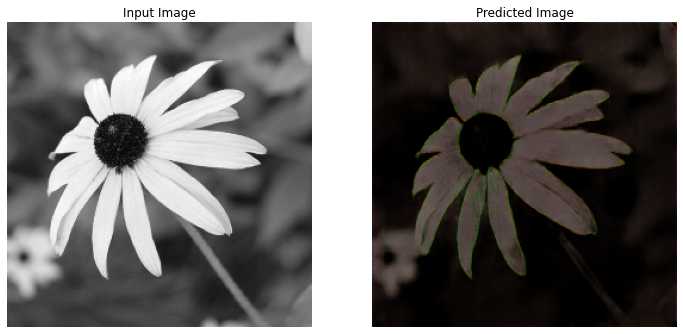

Saving checkpoint for epoch 22 at ../res/checkpoints/train/ckpt-22
Time taken for epoch 22 is 2607.67 s
Step 5286 for epoch 22: 0.24 s. g_g: 0.886, g_f: 0.824, d_x: 0.566, d_y: 0.617

In [ ]:
pathlib.Path('../res/logs/').mkdir(parents=True, exist_ok=True)
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
train_log_dir = '../res/logs/' + current_time + '/train'
train_summary_writer = tf.summary.create_file_writer(train_log_dir)

for epoch in range(loaded_epoch, EPOCHS):
    start_epoch = time.time()
    
    n = 0
    for image_x, image_y in tf.data.Dataset.zip((ds_x_train, ds_y_train)):
        start_step = time.time()
        g_g_loss, g_f_loss, d_x_loss, d_y_loss = train_step(image_x, image_y)
        end_step = time.time()
        with train_summary_writer.as_default():
            tf.summary.scalar('loss_g_g', g_g_loss, step=epoch)
            tf.summary.scalar('loss_g_f', g_f_loss, step=epoch)
            tf.summary.scalar('loss_d_x', d_x_loss, step=epoch)
            tf.summary.scalar('loss_d_y', d_y_loss, step=epoch)

        # clear_output(wait=True)
        # generate_images(generator_g, sample_x)
        n += 1
        print("\rStep {} for epoch {}: {:.2f} s. g_g: {:.3f}, g_f: {:.3f}, d_x: {:.3f}, d_y: {:.3f}".format(n,
            epoch, end_step - start_step, g_g_loss, g_f_loss, d_x_loss, d_y_loss), end='')

    g_g_loss = 0
    g_f_loss = 0
    d_x_loss = 0
    d_y_loss = 0

    clear_output(wait=True)
    generate_images(generator_g, sample_x)

    if (epoch + 1) % EPOCH_CHECKPOINT == 0:
        ckpt_save_path = ckpt_manager.save()
        print('Saving checkpoint for epoch {} at {}'.format(epoch + 1, ckpt_save_path))
    
    end_epoch = time.time()
    print('Time taken for epoch {} is {:.2f} s'.format(epoch + 1, end_epoch - start_epoch))

# Test